In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv
/kaggle/input/fer2018/fer20131.csv
/kaggle/input/fer2018/README
/kaggle/input/fer2018/fer2013.bib
/kaggle/input/fer2018/ferSubmission.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [3]:
data = pd.read_csv('../input/fer2013/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
x_data = data['pixels']
y_data = data['emotion']

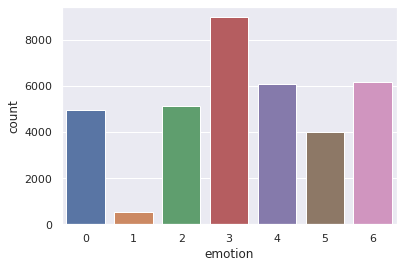

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    164 130 150 176 183 199 212 208 201 201 211 23...
62919    75 76 77 78 81 87 89 87 84 84 95 101 123 180 2...
62920    30 30 30 30 32 33 41 43 30 64 90 103 124 145 1...
62921    63 68 74 98 111 112 116 125 129 132 137 145 15...
62922    70 71 74 33 28 24 20 15 20 30 36 41 42 32 40 3...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [11]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [12]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [14]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

2022-12-04 15:41:47.345522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:41:47.513783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:41:47.514841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 15:41:47.517005: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0

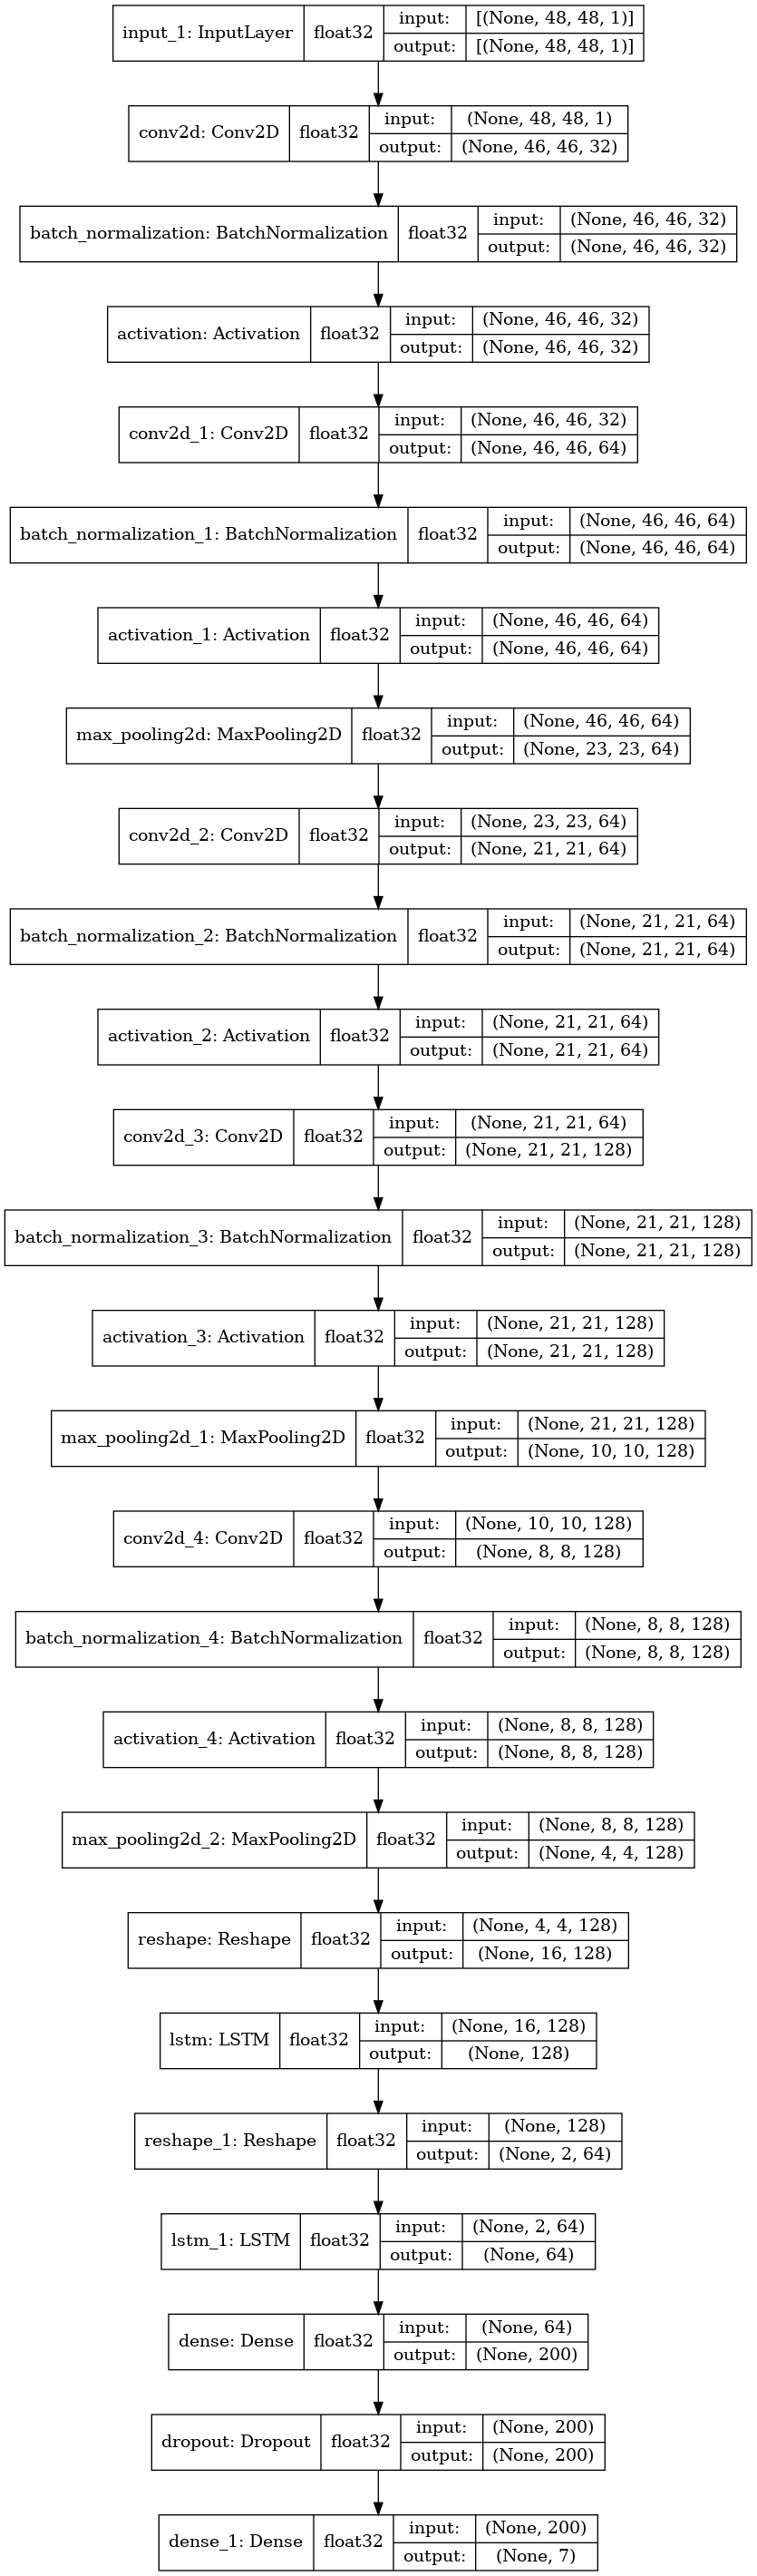

In [15]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [16]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [18]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [19]:
history = model.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

2022-12-04 15:41:53.982626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-04 15:41:58.283539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1770/1770 [==============================] - 32s 12ms/step - loss: 1.5295 - accuracy: 0.4023 - val_loss: 1.1824 - val_accuracy: 0.5436
Epoch 2/30
1770/1770 [==============================] - 21s 12ms/step - loss: 1.1166 - accuracy: 0.5709 - val_loss: 1.1149 - val_accuracy: 0.5632
Epoch 3/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.9680 - accuracy: 0.6329 - val_loss: 1.1156 - val_accuracy: 0.5702
Epoch 4/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.8375 - accuracy: 0.6907 - val_loss: 0.9525 - val_accuracy: 0.6490
Epoch 5/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.7335 - accuracy: 0.7340 - val_loss: 1.0489 - val_accuracy: 0.6119
Epoch 6/30
1770/1770 [==============================] - 21s 12ms/step - loss: 0.6361 - accuracy: 0.7745 - val_loss: 1.3389 - val_accuracy: 0.5573
Epoch 7/30
1770/1770 [==============================] - 20s 11ms/step - loss: 0.5516 - accuracy: 0.8077 - val_loss: 0.9214 - val_accura

In [20]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 6ms/step - loss: 0.9260 - accuracy: 0.8122
Accuracy of our model on validation data :  81.21722340583801 %


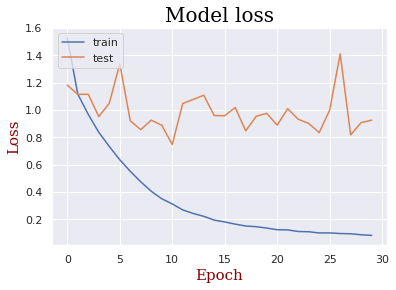

In [22]:
# summarize history for loss
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
cm = plt.figure(figsize = (6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss',  fontdict = font1)
plt.ylabel('Loss', fontdict = font2)
plt.xlabel('Epoch' , fontdict = font2)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
cm.savefig("model_loss")

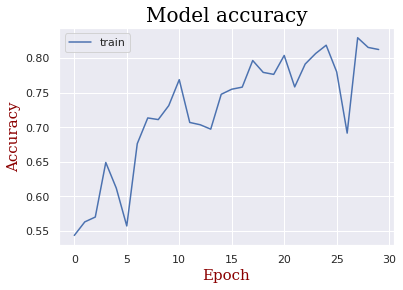

In [23]:
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
cm = plt.figure(figsize = (6,4))
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy',  fontdict = font1)
plt.ylabel('Accuracy', fontdict = font2)
plt.xlabel('Epoch', fontdict = font2)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
cm.savefig("model_acc")


In [24]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[0, 5, 0, 6, 1, 0, 3, 4, 1, 3]

In [25]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80       935
           1       0.99      1.00      0.99       895
           2       0.72      0.81      0.76       880
           3       0.76      0.82      0.79       906
           4       0.76      0.65      0.70       888
           5       0.89      0.95      0.92       869
           6       0.84      0.60      0.70       920

    accuracy                           0.81      6293
   macro avg       0.82      0.81      0.81      6293
weighted avg       0.82      0.81      0.81      6293



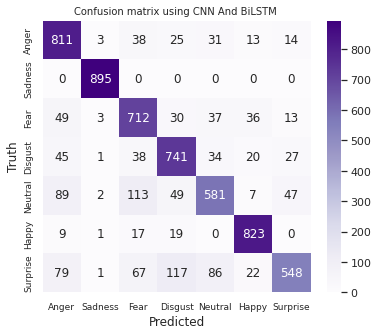

In [27]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (6,5))
ax = plt.axes()
sn.heatmap(cm,cmap="Purples", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=9);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=9);

plt.title('Confusion matrix using CNN And BiLSTM ', fontsize = 10, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')
# plt.supxlabel(["Happy", "Surprise", "Anger", "Sadness", "Fear"], fontsize=9);
# ax.yaxis.set_ticklabels(["Happy", "Surprise", "Anger", "Sadness", "Fear"],  fontsize=9);

plt.savefig("confusion")

In [ ]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save("model.h5") 

[[8.0382591e-01 6.2253466e-04 2.5250616e-03 ... 1.3307542e-02
  9.4773824e-04 5.4420242e-03]
 [2.2190584e-07 1.0333912e-08 6.3097343e-04 ... 2.0371089e-09
  9.9934191e-01 2.1576385e-07]
 [9.9345243e-01 8.3918678e-07 6.5114805e-03 ... 2.4267061e-05
  2.3375293e-07 4.0776368e-07]
 ...
 [1.3281671e-02 3.0221359e-05 9.6571046e-01 ... 9.6918177e-04
  1.9021843e-02 2.1189627e-04]
 [9.9997282e-01 7.3679626e-06 7.4625100e-06 ... 5.6607701e-06
  4.7878494e-08 1.3827089e-06]
 [4.9000207e-08 2.1223494e-08 1.7801519e-04 ... 6.3851346e-10
  9.9981552e-01 9.9542788e-08]]
[2.5250616e-03 6.3097343e-04 6.5114805e-03 ... 9.6571046e-01 7.4625100e-06
 1.7801519e-04]


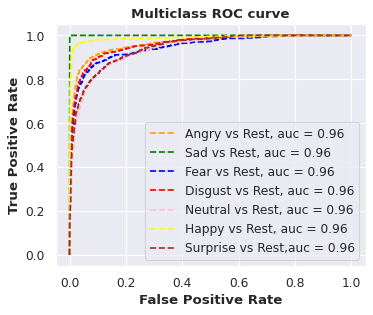

In [28]:
print(y_pred)
y_test =  np.argmax(y_test,axis=1)
predict_x = model.predict(x_test)
# Y_Pred = np.argmax(predict_x,axis=1)
print(predict_x[:,2])


### ROC Curve
# roc curve for classes
from sklearn import metrics
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(y_test,y_prob_pred_cnb,multi_class='ovr',average='weighted')
    
plt.figure(figsize=(5, 4),dpi=80)
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('CNN_LSTM_Multiclass_ROC.png',dpi=80);    